In [1]:
%load_ext autoreload
%autoreload 2

# Setup Paths

In [2]:
import os
import pyrootutils
root = pyrootutils.setup_root(
    search_from='.',
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)
hydra_cfg_path = root / "text_classification_problems" / "configs"
os.chdir(root / "text_classification_problems")

In [3]:
import hydra
from hydra import compose, initialize

from pathlib import Path
import numpy as np
import torch
from core.grads import tree_to_device
from core.tracer import KNN, KNNGD, KNNGN
from sklearn.neighbors import KNeighborsClassifier
from text_classification_problems.datamodule import TextClassifierDataModule
from text_classification_problems.modelmodule import TextClassifierModel
from transformers import AutoTokenizer
from tqdm import tqdm

import matplotlib.pyplot as plt

/host/ThangND34/ErrorDetection/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config  

In [4]:
'..' / hydra_cfg_path.relative_to(root)
with initialize(version_base=None, config_path= '../../configs'):
    cfg = compose(config_name="tracing", return_hydra_config=True, overrides=["datamodule=imdb", "tracer=gd"])

In [5]:
device = 'cuda:2'

# Load Data and Model

In [6]:
from datamodule import TextClassifierDataModule

In [7]:
checkpoint = torch.load("outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints/epoch=01_val_acc=0.8803.ckpt", map_location=device)
datamodule_hparams = checkpoint["datamodule_hyper_parameters"] 

In [8]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)
dm = TextClassifierDataModule(
    data_root=os.environ["PYTORCH_DATASET_ROOT"],
    tokenizer=tokenizer,
    **datamodule_hparams,
    use_denoised_data=True
)
dm.prepare_data()
dm.setup("tracing")

In [9]:
net = hydra.utils.instantiate(cfg.net, num_classes=dm.num_classes)
lit_model = TextClassifierModel(
    net=net,
    num_classes=dm.num_classes,
    lr=1e-3,
)
net = lit_model.net
lit_model.eval()
lit_model.to(device);

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Stats

In [22]:
from core.grads import RuntimeGradientExtractor
from core.tracer import GradientNormalize as GN, GradientCosin as GC, GradientBasedTracer as GD
import torch.nn.functional as F
import pandas as pd
from core.aggregation import cal_neibor_matrices
from text_classification_problems.convert_result import eval_ckpt, loss_fn
from text_classification_problems.run_tracing import register_BatchEncoding
import re
from core.eval import cal_precision_top
from core.mrr import compute_mean_reciprocal_rank
from core.experimental import mahalanobis, pgd
from text_classification_problems.datamodule import _random_subset
import copy
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from core.experimental.viz import plot_results

In [11]:
register_BatchEncoding()

## Collecting

In [12]:
ref_loader = dm.ref_dataloader()
trace_loader = dm.trace_dataloader()
true_error_labels = torch.isin(torch.arange(len(dm.trace_set)), dm.flipped_inds)
sel_ranges = range(50, 1310, 50)
ckpt_dir = Path("outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints")
all_loss_epoch = {}

## Epoch 0

In [23]:
def collecting(lit_model):
    lit_model.eval()
    grad_extractor = RuntimeGradientExtractor(
            lit_model,
            split_params=lambda params: (params[:-2], params[-2:]),
            merge_params=lambda w1, w2: w1 + w2,
            loss_fn=loss_fn,
            input_sample=next(iter(dm.trace_dataloader())),
        )
    all_losses = []
    all_probs = []
    with torch.no_grad():
        for batch in tqdm(trace_loader, desc="Tracing"):
            batch = tree_to_device(batch, device)
            probs = torch.softmax(lit_model(batch), dim=-1)
            grads, losses = grad_extractor.grad_per_input(batch, return_loss=True)
            all_losses.append(losses.cpu())
            all_probs.append(probs.cpu())
    all_losses = torch.cat(all_losses).cpu()
    all_probs = torch.cat(all_probs).cpu()
    return all_losses, all_probs

In [79]:
dm.setup("fit")
trace_set = dm.trace_set
sub_train_set = _random_subset(copy.deepcopy(dm.train_set), 1000, 1204828947)
new_train_dataloader = DataLoader(
    sub_train_set, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True
)
# new_train_dataloader = dm.train_dataloader()
val_loader = dm.val_dataloader()

In [119]:
net = hydra.utils.instantiate(cfg.net, num_classes=dm.num_classes)
lit_model = TextClassifierModel(
    net=net,
    num_classes=dm.num_classes,
    lr=5e-5,
)
# lit_model.loss_fn = pgd.GeneralizedCELoss(q=0.7)
# callbacks=[pgd.FeatureExtractorFreezeUnfreeze()], 
trainer = pl.Trainer(enable_checkpointing=False, max_epochs=3, accelerator="gpu", devices=1, logger=False)
trainer.fit(lit_model, train_dataloaders=new_train_dataloader,val_dataloaders=val_loader)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOC

Epoch 2: 100%|██████████| 91/91 [00:19<00:00,  4.67it/s, loss=0.276, val/loss=0.381, val/acc=0.861, train/acc_epoch=0.886]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 91/91 [00:19<00:00,  4.67it/s, loss=0.276, val/loss=0.381, val/acc=0.861, train/acc_epoch=0.886]


In [120]:
lit_model.to(device)
lit_model.eval()
all_losses, all_probs = collecting(lit_model) 

{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


Tracing: 100%|██████████| 21/21 [00:04<00:00,  5.23it/s]


(50.0, 100.0)

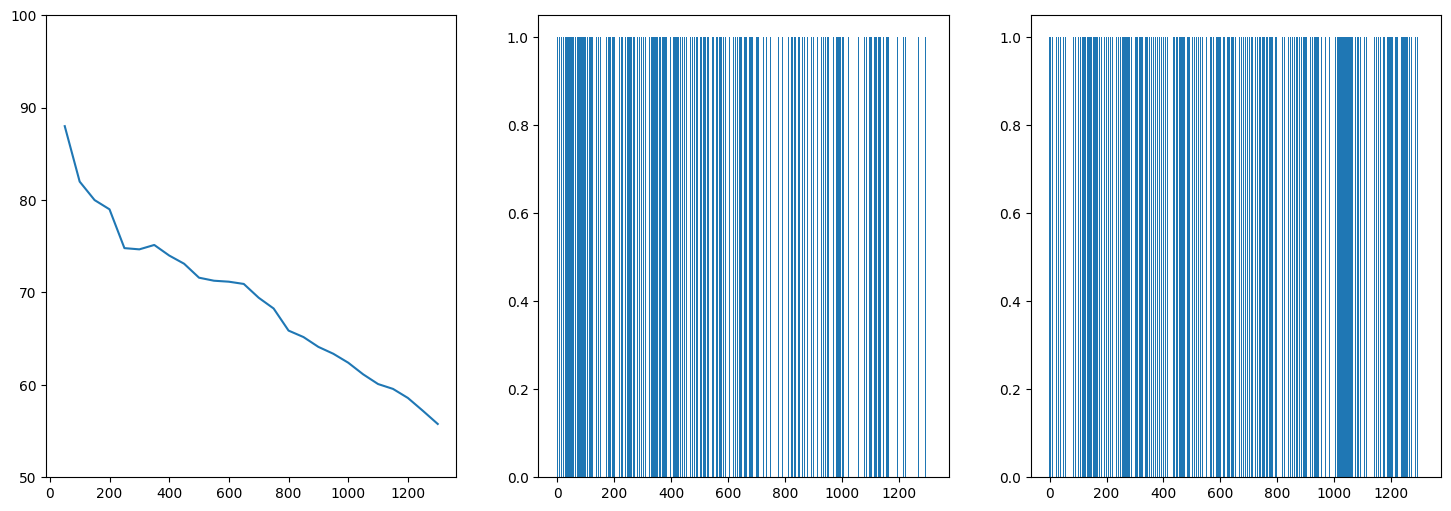

In [121]:
precs, label_ranking, right_traces, _ = cal_precision_top(all_losses, true_error_labels, sel_ranges, descending=True)
# Bias model
fig, axes = plot_results(sel_ranges, precs, label_ranking, right_traces)
axes[0].set_ylim((50, 100))

(50.0, 100.0)

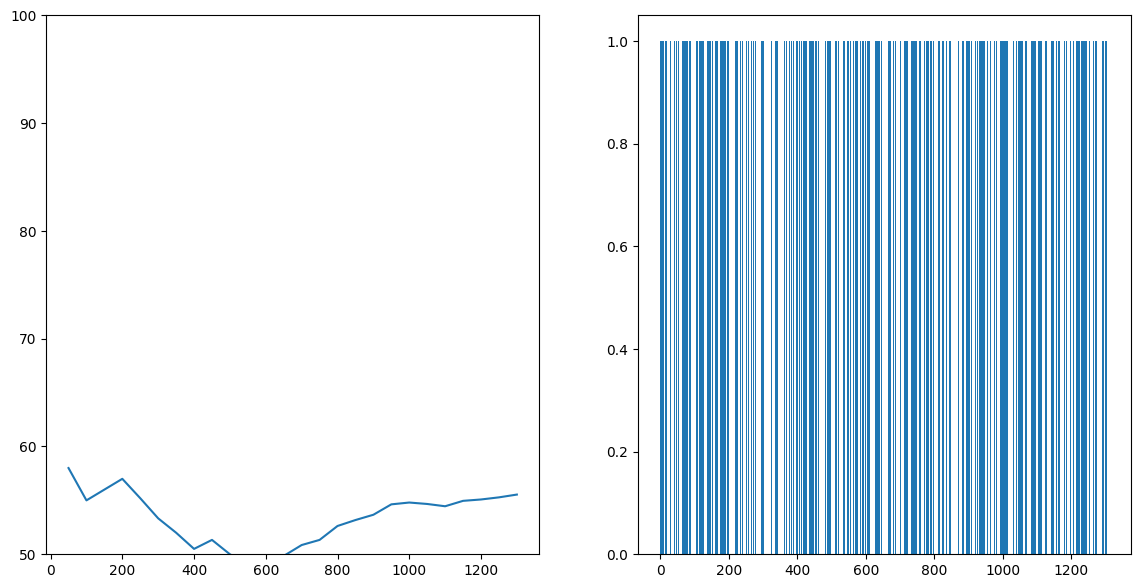

In [59]:
# Bias model, Increase learning rate
fig, axes = plot_results(sel_ranges, precs, label_ranking)
axes[0].set_ylim((50, 100))

(50.0, 100.0)

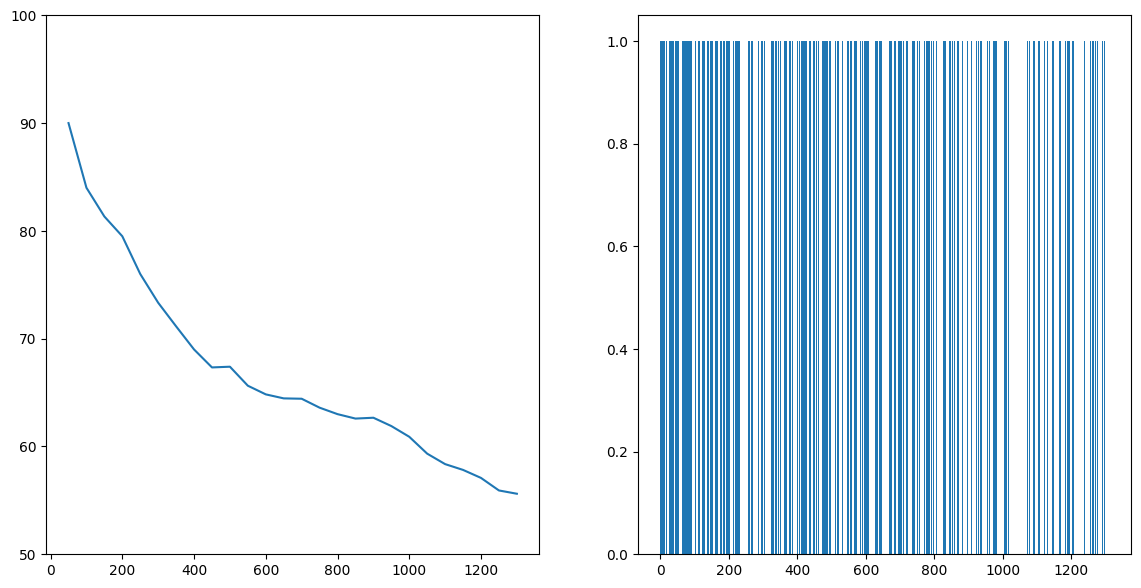

In [68]:
# Bias model, Increase learning rate
fig, axes = plot_results(sel_ranges, precs, label_ranking)
axes[0].set_ylim((50, 100))